In [1]:
import glob
import os 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2
import shutil
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir=r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
classes_dir=['COVID-19(-)','COVID-19(+)']

In [4]:
path_train=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/train"
path_valid=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/val"
path_test=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/test"

In [5]:
assign_dict = {"NORMAL":0, "COVID":1}
img_size = 175

In [6]:
def get_data(directory):
    data = []
    for sub_directory in os.listdir(directory):
        if sub_directory == "NORMAL":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),1)#Il spécifie de charger une image en mode niveaux de gris. Alternativement, on peut passer la valeur entière 0 pour cet indicateur.
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])  
        if sub_directory == "COVID":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
    random.shuffle(data)  
    return np.array(data)

In [7]:
test = get_data(path_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
def preprocessing_data(L):
    X=[]; y=[]
    for features,label in L:
        X.append(features)
        y.append(label)
    X=np.array(X).reshape(-1, img_size, img_size, 3)/255
    return X,np.array(y)

In [9]:
X_test, y_test = preprocessing_data(test)

In [10]:
from keras.models import load_model

model_CNN = load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/Basic_CNN.h5')
model_vgg = load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_vgg.h5')
model_vgg_trainable = load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_vgg_trainable.h5')
model_Resnet_untrainable = load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_Resnet_Untrainable.h5')

In [11]:
models_dict = {'CNN model': model_CNN,
               'ResNet model': model_Resnet_untrainable,
               'VGG model': model_vgg, 
               'VGG model changed': model_vgg_trainable}

In [ ]:
model_CNN.evaluate(X_test,y_test)

27/27 [==============================] - 21s 744ms/step - loss: 3.1227 - accuracy: 0.5802


[3.1226696968078613, 0.580232560634613]

In [ ]:
model_vgg.evaluate(X_test, y_test)

27/27 [==============================] - 308s 11s/step - loss: 0.1867 - accuracy: 0.9372


[0.18665321171283722, 0.9372093081474304]

In [ ]:
model_vgg_trainable.evaluate(X_test, y_test)

27/27 [==============================] - 307s 11s/step - loss: 0.1617 - accuracy: 0.9430


[0.16173410415649414, 0.9430232644081116]

In [ ]:
model_Resnet_untrainable.evaluate(X_test, y_test)

27/27 [==============================] - 86s 3s/step - loss: 0.3595 - accuracy: 0.8535


[0.35948726534843445, 0.8534883856773376]

In [13]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

models=[model_CNN, model_vgg, model_vgg_trainable, model_Resnet_untrainable]
def evaluation(model):
    if model==model_CNN:
    y_pred = model.predict_classes(X_test)
    else:
    y_pred = model.predict(X_test)
    print('Confusion Matrix')
    cm=confusion_matrix(y_test, np.array(np.round(y_pred), dtype='int'))

    plt.imshow(cm, cmap=plt.cm.winter)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    tick_marks = np.arange(len(classes_dir))
    plt.xticks(tick_marks, classes_dir)
    plt.yticks(tick_marks, classes_dir)
    plt.title('Confusion matrix ')

    for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",)

    plt.show()
    print('Classification Report')
    print(classification_report(y_test, np.array(np.round(y_pred), dtype='int'), target_names=classes_dir))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix


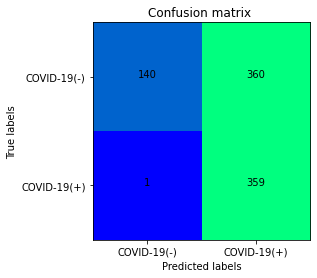

Classification Report
              precision    recall  f1-score   support

 COVID-19(-)       0.99      0.28      0.44       500
 COVID-19(+)       0.50      1.00      0.67       360

    accuracy                           0.58       860
   macro avg       0.75      0.64      0.55       860
weighted avg       0.79      0.58      0.53       860

Confusion Matrix


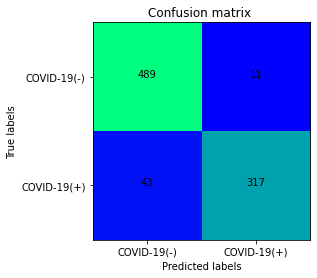

Classification Report
              precision    recall  f1-score   support

 COVID-19(-)       0.92      0.98      0.95       500
 COVID-19(+)       0.97      0.88      0.92       360

    accuracy                           0.94       860
   macro avg       0.94      0.93      0.93       860
weighted avg       0.94      0.94      0.94       860

Confusion Matrix


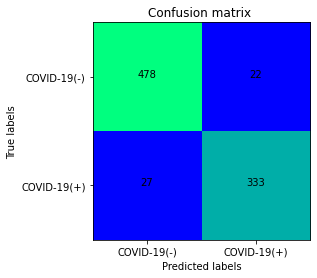

Classification Report
              precision    recall  f1-score   support

 COVID-19(-)       0.95      0.96      0.95       500
 COVID-19(+)       0.94      0.93      0.93       360

    accuracy                           0.94       860
   macro avg       0.94      0.94      0.94       860
weighted avg       0.94      0.94      0.94       860

Confusion Matrix


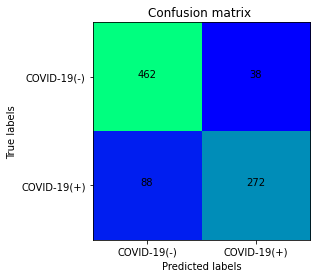

Classification Report
              precision    recall  f1-score   support

 COVID-19(-)       0.84      0.92      0.88       500
 COVID-19(+)       0.88      0.76      0.81       360

    accuracy                           0.85       860
   macro avg       0.86      0.84      0.85       860
weighted avg       0.86      0.85      0.85       860



In [14]:
for model in models:
    evaluation(model)

In [20]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 

def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            prob = clf.predict(X_test)
            y_score = np.array(np.round(prob), dtype='int')
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8,4))
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.plot([0.0, 1.0], linewidth=2, linestyle = 'dashed', color='black')
        plt.legend()


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


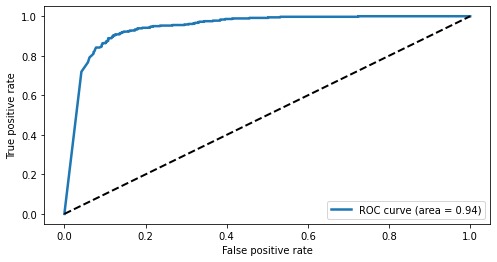

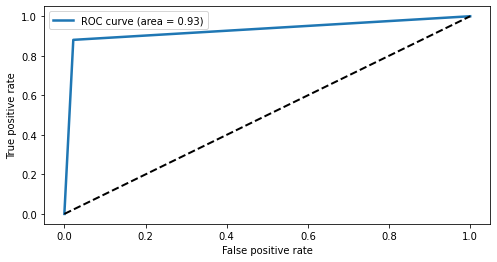

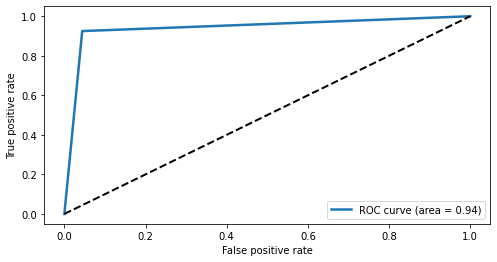

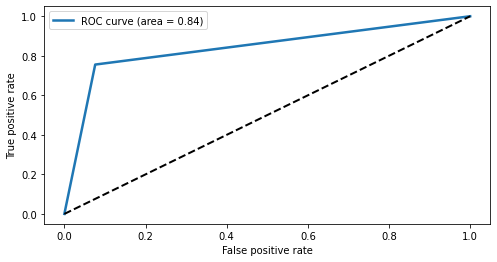

In [21]:
plot_model_roc_curve(model_CNN , X_test ,
                         y_test, 
                         class_names=[0, 1])

plot_model_roc_curve(model_vgg, X_test ,
                         y_test, 
                         class_names=[0, 1]) 

plot_model_roc_curve(model_vgg_trainable , X_test ,
                         y_test, 
                         class_names=[0, 1]) 

plot_model_roc_curve(model_Resnet_untrainable , X_test ,
                         y_test, 
                         class_names=[0, 1])